In [1]:
# export TF_ENABLE_ONEDNN_OPTS=0
# for a in /sys/bus/pci/devices/*; do echo 0 | sudo tee -a $a/numa_node; done

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpu_devices = tf.config.list_physical_devices('GPU')
for device in gpu_devices:
    print(device)
    tf.config.experimental.set_memory_growth(device, True)

Num GPUs Available:  1
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 578660911307441088
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 857341952
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12300080348263577181
physical_device_desc: "device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:00:0d.0, compute capability: 8.0"
xla_global_id: 416903419
]


2023-12-22 19:30:49.721942: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /device:GPU:0 with 817 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:00:0d.0, compute capability: 8.0


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

DATA = r"./fundamental_data/all_data_no_dates.csv"
SAVE = "./models/fundamental_model_eurusd_300epochs.keras"

dataframe = read_csv(DATA, engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

In [6]:
# cut off first 5 values
dataset = dataset[5:]
dataset = dataset[:, 1:]

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

In [6]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)


look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], look_back, 8))
testX = np.reshape(testX, (testX.shape[0], look_back, 8))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(50, input_shape=(look_back, 8)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(trainX, trainY, epochs=300, batch_size=16, verbose=1)
model.save(SAVE)

2023-12-22 15:59:43.254817: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 816 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:00:0d.0, compute capability: 8.0
2023-12-22 15:59:43.335040: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Epoch 1/300


2023-12-22 15:59:44.856571: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


  1/199 [..............................] - ETA: 5:30 - loss: 0.3653

2023-12-22 15:59:45.249177: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fbf215d09e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-22 15:59:45.249204: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2023-12-22 15:59:45.253696: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1703260785.343210   86993 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


199/199 [==============================] - 2s 3ms/step - loss: 0.0180
Epoch 2/300
199/199 [==============================] - 0s 2ms/step - loss: 6.0509e-04
Epoch 3/300
199/199 [==============================] - 0s 2ms/step - loss: 4.4103e-04
Epoch 4/300
199/199 [==============================] - 0s 2ms/step - loss: 3.7163e-04
Epoch 5/300
199/199 [==============================] - 0s 2ms/step - loss: 3.4994e-04
Epoch 6/300
199/199 [==============================] - 0s 2ms/step - loss: 3.5967e-04
Epoch 7/300
199/199 [==============================] - 0s 2ms/step - loss: 3.2835e-04
Epoch 8/300
199/199 [==============================] - 0s 2ms/step - loss: 3.4851e-04
Epoch 9/300
199/199 [==============================] - 0s 2ms/step - loss: 3.5102e-04
Epoch 10/300
199/199 [==============================] - 0s 2ms/step - loss: 3.3732e-04
Epoch 11/300
199/199 [==============================] - 0s 2ms/step - loss: 3.4409e-04
Epoch 12/300
199/199 [==============================] - 0s 2ms/step 

25/25 [==============================] - 0s 1ms/step


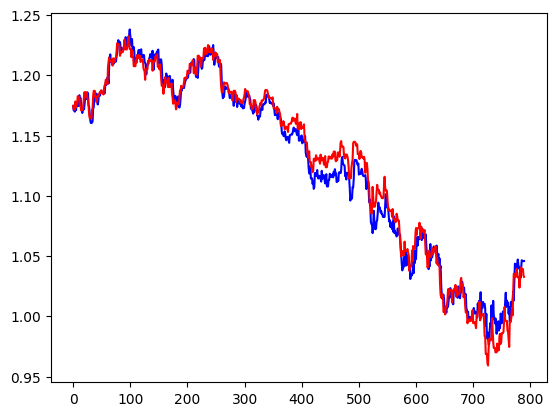

Test Score: 0.010508 RMSE


In [7]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = np.squeeze(trainPredict)
testPredict = np.squeeze(testPredict)

def inverse_transform(arr):
    extended = np.zeros((len(arr), 8))
    extended[:, 0] = arr
    return scaler.inverse_transform(extended)[:, 0]

trainPredict = inverse_transform(trainPredict)
testPredict = inverse_transform(testPredict)
trainY = inverse_transform(trainY)
testY = inverse_transform(testY)

# shift predictions up by one
testPredict = np.delete(testPredict, -1)
testY = np.delete(testY, 0)

plt.plot(testPredict, color="blue")
plt.plot(testY, color="red")
plt.savefig('tmp/fundamental_data.png')
plt.show()
testScore = np.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.6f RMSE' % (testScore))